# Comparing second order methods to Adam 

In [3]:
from skimage.transform import rescale
from skimage.feature import register_translation
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import scipy
import tensorflow as tf
from optimizers.tensorflow import Curveball

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def getPositions(obj_npix, probe_npix, step_size):
    #step_size = (obj_npix - probe_npix) // num_steps 
    positions_x = np.arange(0, obj_npix - probe_npix, step_size)
    positions = []
    for r in positions_x:
        for c in positions_x:
            positions.append([r, c])
    return np.array(positions)

In [4]:
def getDiffractionMods(obj_flat, probe_flat, obj_shape, probe_shape, positions):
    obj = np.reshape(obj_flat, obj_shape)
    probe = np.reshape(probe_flat, probe_shape)
    diffraction_mods = []
    #diffraction_mods = np.zeros(positions.shape[0] * probe.shape[0] * probe.shape[1], dtype='float32')
    for indx, (r, c) in enumerate(positions):
        r2 = r + probe.shape[0]
        c2 = c + probe.shape[0]
        obj_slice = obj[r:r2, c:c2]
        exit_wave = probe * obj_slice
        farfield_wave = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(exit_wave), norm='ortho'))
        diffraction_mods.append(np.abs(farfield_wave))
    return np.array(diffraction_mods)

/raid/home/skandel/anaconda3/envs/tensorflow17/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


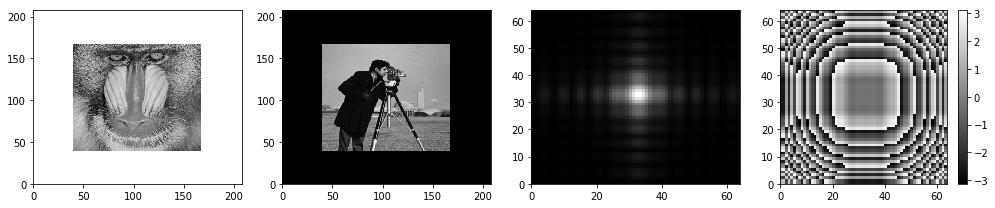

In [123]:
#obj_npix = 512
obj_true_large = getTestImage()
obj_true_abs = rescale(np.abs(obj_true_large), preserve_range=True, scale=0.25)
obj_true_phase = rescale(np.angle(obj_true_large), preserve_range=True, scale=0.25)
obj_true = obj_true_abs * np.exp(1j * obj_true_phase)
pad = 40
obj_padded = np.pad(obj_true, [[pad,pad],[pad,pad]], mode='constant',constant_values=1.)
obj_npix = obj_padded.shape[0]

n_photons = 1e4
probe_true = np.load('../probe_square_prop.npy')#[16:48, 16:48]
probe_npix = probe_true.shape[0]
probe_true = probe_true / np.sqrt(np.sum(np.abs(probe_true)**2)) * np.sqrt(n_photons)

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(probe_true), cmap='gray')
cax3 = axs[3].pcolormesh(np.angle(probe_true), cmap='gray')
plt.colorbar(cax3)
plt.tight_layout()
plt.show()

In [124]:
positions = getPositions(obj_npix, probe_npix, 6)
diffraction_mods = getDiffractionMods(obj_padded.flatten(),
                                      probe_true.flatten(),
                                      obj_padded.shape, 
                                      probe_true.shape,
                                      positions)

diffraction_mods = np.sqrt(np.random.poisson(diffraction_mods**2))
#norm_factor = diffraction_mods.size**0.5

## Adding a little bit of padding to the reconstructed object (in case the noise introduces fluctuations at the edges)

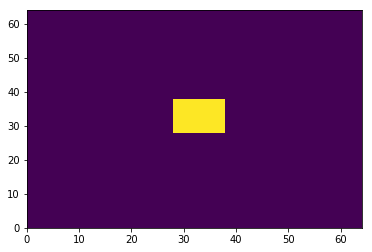

In [125]:
recons_pad = 3
obj_recons_shape = np.array(obj_true.shape) + recons_pad * 2
#obj_guess = np.random.randn(*obj_true.shape) + 1j * np.random.randn(*obj_true.shape)
obj_guess = np.random.randn(*obj_recons_shape) * np.exp(1j * np.random.randn(*obj_recons_shape))

pad_recons = pad - recons_pad

obj_true_target = obj_padded[pad-recons_pad:-pad+recons_pad, pad-recons_pad:-pad+recons_pad]

probe_guess = np.zeros_like(probe_true)
probe_guess[28:38, 28:38] = 1
probe_guess = probe_guess * np.sqrt(n_photons/np.sum(np.abs(probe_guess)**2))
plt.pcolormesh(np.abs(probe_guess))
plt.show()

#probe_guess = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(np.mean(diffraction_mods, axis=0)), norm='ortho'))
ndiffs = diffraction_mods.shape[0]

## Adam gradient descent (batch)

In [136]:
pr_adam = tfAdamPhaseRetriever(diffraction_mods, 
                             positions, 
                             obj_guess, 
                             probe_guess, 
                             batch_size=128, 
                             obj_padding=[[pad_recons, pad_recons],[pad_recons,pad_recons]],
                             obj_padding_const=1.,
                             learning_rate_probe=1e0,
                             learning_rate_obj=1e-2)

In [137]:
%%time
adam_errors = []
for i in tqdm(range(100)):
    if i < 1:
        pr_adam.run(10, n_probe_fixed_iterations=50, disable_progress_bar=True)
    else:
         pr_adam.run(10, n_probe_fixed_iterations=0, disable_progress_bar=True)
    recons_obj = pr_adam.obj
    shift, err, phase = register_translation(recons_obj, obj_true_target, upsample_factor=10)
    shift, err, phase = register_translation(recons_obj * np.exp(-1j * phase), obj_true_target, upsample_factor=10)
    adam_errors.append(err)
    if i % 50 == 0: print(shift, err, phase)
    if err < 0.02: break

  1%|          | 1/100 [00:00<00:37,  2.62it/s]

[-25.5  63.6] 0.9997534551623724 0.019649192242373992


 52%|█████▏    | 52/100 [00:06<00:06,  7.51it/s]

[-25.  -23.4] 0.6930866073826062 -0.0028684641256073898


100%|██████████| 100/100 [00:14<00:00,  6.80it/s]

CPU times: user 4min 23s, sys: 17.2 s, total: 4min 40s
Wall time: 14.7 s


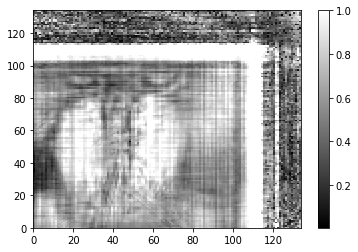

In [138]:
plt.pcolormesh(np.abs(pr_adam.obj), cmap='gray')
plt.colorbar()
plt.show()

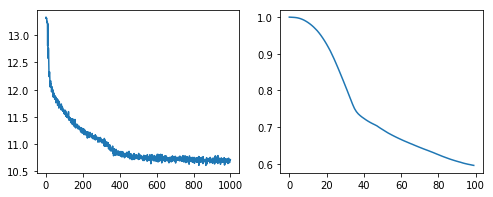

In [139]:
fig, axs = plt.subplots(1,2,figsize=[8,3])
axs[0].plot(np.log(pr_adam.losses))
axs[1].plot(adam_errors)
plt.show()

# CG

In [140]:
pr_cg = tfCGPhaseRetriever(diffraction_mods, 
                             positions, 
                             obj_guess, 
                             probe_guess, 
                             batch_size=128, 
                             obj_padding=[[pad_recons, pad_recons],[pad_recons,pad_recons]],
                             obj_padding_const=1.,
                             max_iter_per_step=1)

In [141]:
%%time
cg_errors = []
for i in tqdm(range(100)):
    if i < 1:
        pr_cg.run(10, n_probe_fixed_iterations=50, disable_progress_bar=True)
    else:
         pr_cg.run(10, n_probe_fixed_iterations=0, disable_progress_bar=True)
    recons_obj = pr_cg.obj
    shift, err, phase = register_translation(recons_obj, obj_true_target, upsample_factor=10)
    shift, err, phase = register_translation(recons_obj * np.exp(-1j * phase), obj_true_target, upsample_factor=10)
    cg_errors.append(err)
    if i % 20==0: print(shift, err, phase)
    if err < 0.02: break

  1%|          | 1/100 [00:00<01:22,  1.21it/s]

[-0.5  2. ] 0.9639475491299161 0.0019246770535460216


 21%|██        | 21/100 [00:13<00:50,  1.56it/s]

[0.1 0.4] 0.3548614685898053 0.0025506239059706233


 41%|████      | 41/100 [00:25<00:36,  1.61it/s]

[0.9 1. ] 0.17371317284665902 3.962193265015219e-10


 61%|██████    | 61/100 [00:37<00:23,  1.63it/s]

[1. 1.] 0.14975144630108658 3.234163186390567e-11


 81%|████████  | 81/100 [00:49<00:11,  1.64it/s]

[1.  1.1] 0.14583574671025337 -1.7383115546940738e-10


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]

CPU times: user 18min 21s, sys: 1min 43s, total: 20min 4s
Wall time: 1min


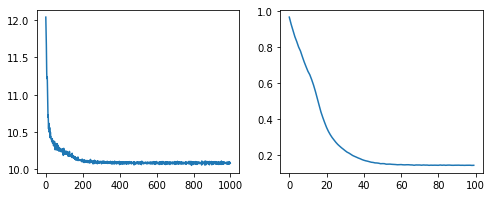

In [142]:
fig, axs = plt.subplots(1,2,figsize=[8,3])
axs[0].plot(np.log(pr_cg.losses))
axs[1].plot(cg_errors)
plt.show()

## Curveball
Ref: https://arxiv.org/pdf/1805.08095v1.pdf

In [155]:
pr_cb = tfCurveballPhaseRetriever(diffraction_mods, 
                                  positions, 
                                  obj_guess, 
                                  probe_guess, 
                                  batch_size=ndiffs, 
                                  obj_padding=[[pad_recons, pad_recons],[pad_recons,pad_recons]],
                                  obj_padding_const=1.0)

In [156]:
%%time
cb_errors = []
for i in tqdm(range(100)):
    if i < 1:
        pr_cb.run(10, n_probe_fixed_iterations=50, disable_progress_bar=True, obj_clip=False)
    else:
        pr_cb.run(10, n_probe_fixed_iterations=0, disable_progress_bar=True, obj_clip=False)
    recons_obj = pr_cb.obj
    shift, err, phase = register_translation(recons_obj, obj_true_target, upsample_factor=10)
    shift, err, phase = register_translation(recons_obj * np.exp(-1j * phase), obj_true_target, upsample_factor=10)
    cb_errors.append(err)
    if i % 20 == 0: print(shift, err, phase)
    if err < 0.02: break

  1%|          | 1/100 [00:01<01:50,  1.11s/it]

[-2.   1.8] 0.6431926667232809 0.00037279542693692585


 21%|██        | 21/100 [00:09<00:36,  2.15it/s]

[1. 1.] 0.12986560818260107 7.691584570495112e-11


 41%|████      | 41/100 [00:17<00:25,  2.34it/s]

[1.1 1. ] 0.12966846787468464 -2.1957896497675183e-10


 61%|██████    | 61/100 [00:25<00:16,  2.41it/s]

[1.1 1. ] 0.12966720130566997 -5.7266500678861444e-11


 81%|████████  | 81/100 [00:33<00:07,  2.45it/s]

[1.1 1. ] 0.12966897773760327 -2.301377596487323e-10


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]

CPU times: user 8min 28s, sys: 54.1 s, total: 9min 22s
Wall time: 40.5 s


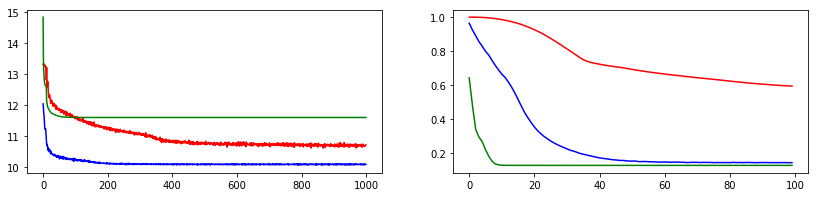

In [157]:
fig, axs = plt.subplots(1,2,figsize=[14,3])
axs[0].plot(np.log(pr_adam.losses), color='red')
axs[0].plot(np.log(pr_cg.losses), color='blue')
axs[0].plot(np.log(pr_cb.losses), color='green')
axs[1].plot(adam_errors, color='red')
axs[1].plot(cg_errors, color='blue')
axs[1].plot(cb_errors, color='green')
plt.show()

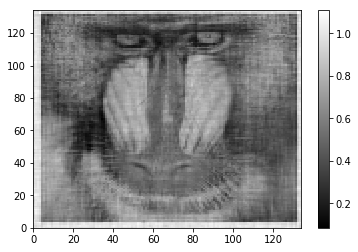

In [158]:
plt.pcolormesh(np.abs(pr_cb.obj), cmap='gray')
plt.colorbar()
plt.show()
    